In [1]:
#Check correlations between higher moments of daily tasmax distr between EOC and pre-ind periods

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#import numbers
#np.set_printoptions(threshold=np.inf)
#from scipy.special import erfinv, erf
from scipy.stats import skew
import xskillscore as xs
from scipy.stats import skewnorm
from scipy.special import erfinv, erf
from sklearn.metrics import mean_squared_error

In [3]:
########## CONUS ############
#CONUS lat-lon
ctop    = 50.0 # north lat
cleft   = (360-124.7844079)%360 # west long
cright  = (360-66.9513812)%360# east long
cbottom =  24.7433195 # south lat
################################
#Europe lat-lon
eutop     = 60.0
eubottom  = 35.0
euleft    = (360-10.0)%360
euright   = 50
# # #Bengaluru:
LAT        = 12.9716
LON        = 77.5946
################################
cesm2_path       = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals            = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals1           = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
era5_path        = '/global/scratch/users/harsha/ERA5/tasmax/'
era5_noleap_path = '/global/scratch/users/harsha/ERA5/tasmax/era5_noleap_1950_2021.zarr'
##############################
print(cleft,cright)
print(euleft,euright)

235.21559209999998 293.0486188
350.0 50


In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(4)

In [5]:
cluster

In [6]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [7]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x

In [8]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [9]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number netween 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [10]:
def global_annual_rmse(arr_err, dim):
      #Compute spatially weighted global mean of square error
      # and then compute annual rmse #g = global, a= annual
        arr_err_sq            = arr_err**2
        weights               = np.cos(np.deg2rad(arr_err_sq.lat))
        weights.name          = "weights"
        arr_serror_weighted   = arr_err_sq.weighted(weights)
        arr_serror_gmean      = arr_serror_weighted.mean({'lat','lon'})
        ####
        arr_gamse             = arr_serror_gmean.mean(dim)
        arr_garmse            = np.sqrt(arr_gamse)
        
        return arr_garmse

In [11]:
def global_mean(arr):
      #Compute spatially weighted global mean of square error
      # and then compute annual rmse #g = global, a= annual
        weights            = np.cos(np.deg2rad(arr.lats))
        weights.name       = "weights"
        arr_weighted       = arr.weighted(weights)
        arr_gmean          = arr_weighted.mean({'lats','lons'})
        return arr_gmean 

In [12]:
def transform_to_loc(mean):
    return mean  # replace with the correct transformation

def transform_to_scale(std):
    return std  # replace with the correct transformation

def transform_to_a(skewness):
    return skewness  # replace with the correct transformation

def get_percentile(a, loc, scale, percentile):
    return skewnorm.ppf(percentile, a, loc, scale)

In [13]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [14]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 1.63 s, sys: 349 ms, total: 1.98 s
Wall time: 13.3 s


In [15]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))       
tghw   = ds_hist.TREFHTMX
#tgnw

CPU times: user 107 ms, sys: 3.91 ms, total: 111 ms
Wall time: 109 ms


In [16]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) 
#Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1))
#Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
#tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 833 ms, sys: 49 ms, total: 882 ms
Wall time: 869 ms


In [17]:
%%time
tgmw_d    = to_daily(tgmw)
tgmw_dpi  = tgmw_d.sel(year=slice(1850,1879))
tgmw_deoc = tgmw_d.sel(year=slice(ic_year0,ic_year1))
tgmw_deoc = tgmw_deoc.chunk({'day':30})
tgmw_dpi  = tgmw_dpi.chunk({'day':30})
#tgmw_deoc

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


CPU times: user 948 ms, sys: 24.6 ms, total: 973 ms
Wall time: 960 ms


In [18]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants             = np.arange(0,1.01,0.01)
N_mem              = 100
window_len         = 30
#r = roll, ndrop = drop NANs
tgmw_eocroll       = stack_roll(tgmw_deoc,N_mem*window_len,N_mem)
tgmw_piroll        = stack_roll(tgmw_dpi,N_mem*window_len,N_mem)
#########
tgmw_eocroll0      = tgmw_eocroll.sel(ym=[15])
tgmw_piroll0       = tgmw_piroll.sel(ym=[15])
#tgmw_eocroll0

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365, ym: 3000)>
dask.array<reshape, shape=(192, 288, 365, 3000), dtype=float32, chunksize=(20, 30, 30, 300), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 2071 2071 2071 2071 2071 ... 2100 2100 2100 2100 2100
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
Dimensions without coordinates: ym
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K
<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365, ym: 3000)>
dask.array<reshape, shape=(192, 288, 365, 3000), dtype=float32, chunksize=(20, 30, 30, 300), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 

In [19]:
######## A direct calcualtion of skewness is leading to precison loss #####
#stnd = standardized
tgmw_piroll_stnd   = (tgmw_piroll0 -tgmw_piroll0.mean('index') )/tgmw_piroll0.std('index')
tgmw_eocroll_stnd  = (tgmw_eocroll0 -tgmw_eocroll0.mean('index') )/tgmw_eocroll0.std('index')
#
tgmw_pi_stnd_cube  = tgmw_piroll_stnd**3
tgmw_eoc_stnd_cube = tgmw_eocroll_stnd**3
#
skew_gpi           = tgmw_pi_stnd_cube.mean('index')
skew_geoc          = tgmw_eoc_stnd_cube.mean('index')
skew_gpi

,Array,Chunk
Bytes,76.99 MiB,70.31 kiB
Shape,"(192, 288, 365, 1)","(20, 30, 30, 1)"
Count,214511 Tasks,1300 Chunks
Type,float32,numpy.ndarray


In [20]:
%%time
################## Save skewness values #######
skew_gpipath      = cvals+'skew_gpi'+'_'+pi_year0+'_'+pi_year1+'.zarr'
#skew_gpi.to_dataset().to_zarr(skew_gpipath,mode='w')

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11 µs


In [21]:
%%time
skew_geocpath      = cvals+'skew_geoc'+'_'+pi_year0+'_'+pi_year1+'.zarr'
#skew_geoc.to_dataset().to_zarr(skew_geocpath,mode='w')

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 15.3 µs


In [22]:
##### Open and compute correlations #####
skew_geoc = xr.open_zarr(skew_geocpath)
skew_gpi  = xr.open_zarr(skew_gpipath)
skew_geoc = skew_geoc.TREFHTMX
skew_gpi  = skew_gpi.TREFHTMX
skew_diff = skew_geoc - skew_gpi

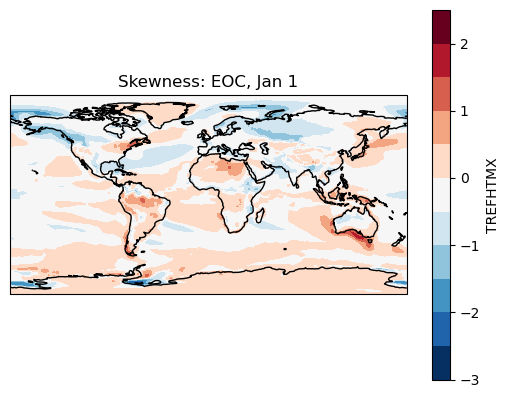

CPU times: user 2.22 s, sys: 117 ms, total: 2.33 s
Wall time: 2.81 s


In [26]:
%%time
#### Plot for Jan 1 #####
levels        = np.arange(-3,3,0.5)
ax            = plt.axes(projection=cart.crs.PlateCarree())
skew_geoc.sel(day=1,ym=0).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levels)
ax.coastlines(color="black")
plt.title('Skewness: EOC, Jan 1')
plt.show()

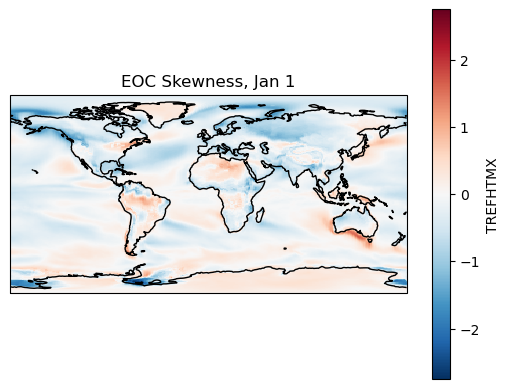

CPU times: user 2.59 s, sys: 112 ms, total: 2.71 s
Wall time: 2.79 s


In [24]:
# %%time
# #### Plot for Jan 1 #####
# ax            = plt.axes(projection=cart.crs.PlateCarree())
# skew_geoc.sel(day=1).plot(ax=ax,transform=cart.crs.PlateCarree())
# # plt.plot(-87.629,41.94,marker='*',color='tab:orange')
# # plt.plot(77.5,12.72,marker='*',color='tab:brown')
# ax.coastlines(color="black")
# plt.title('EOC Skewness, Jan 1')
# plt.show()

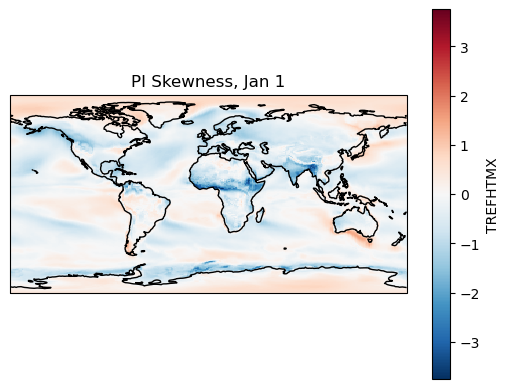

In [25]:
# ax            = plt.axes(projection=cart.crs.PlateCarree())
# skew_gpi.sel(day=1).plot(ax=ax,transform=cart.crs.PlateCarree())
# ax.coastlines(color="black")
# plt.title('PI Skewness, Jan 1')
# plt.show()

In [26]:
%%time
############ Get Mean absolute error #############
skew_geoc = skew_geoc.chunk(dict(day=-1)).sel(ym=0)
skew_gpi  = skew_gpi.chunk(dict(day=-1)).sel(ym=0)
skew_gpi

CPU times: user 21.5 ms, sys: 19 µs, total: 21.5 ms
Wall time: 20.5 ms


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365)>
dask.array<getitem, shape=(192, 288, 365), dtype=float32, chunksize=(20, 30, 365), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   int64 dask.array<chunksize=(), meta=np.ndarray>
    year     int64 dask.array<chunksize=(), meta=np.ndarray>

In [27]:
# skew_mae      = xs.mae(skew_geoc,skew_gpi,dim='day')
# ax            = plt.axes(projection=cart.crs.PlateCarree())
# skew_mae.plot.contourf(ax=ax,transform=cart.crs.PlateCarree())
# ax.coastlines(color="black")
# plt.title('MAE Skewness')
# plt.show()

In [28]:
########## Compute correlation between daily skewness for pre-ind and end of century ####

In [29]:
%%time
skew_corr         = xr.corr(skew_geoc,skew_gpi,dim=['lat','lon'])
skew_geoc         = skew_geoc.chunk(dict(lat=-1,lon=-1))
skew_gpi          = skew_gpi.chunk(dict(lat=-1,lon=-1))
skew_geoc_absmean = np.abs(skew_geoc).mean(dim=['lat','lon'])
skew_gpi_absmean  = np.abs(skew_gpi).mean(dim=['lat','lon'])
skew_rmse         = xs.rmse(skew_geoc,skew_gpi,dim=['lat','lon'])
skew_rmse

CPU times: user 373 ms, sys: 21.1 ms, total: 394 ms
Wall time: 1.1 s


<xarray.DataArray 'TREFHTMX' (day: 365)>
dask.array<transpose, shape=(365,), dtype=float64, chunksize=(365,), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
    member   int64 0

In [30]:
%%time 
#### Save skew correlations (pearson) ######
skew_corrpath      = cvals+'skew_corr_eoc_pi.zarr'
# skew_corr.to_dataset().to_zarr(skew_corrpath,mode='w')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


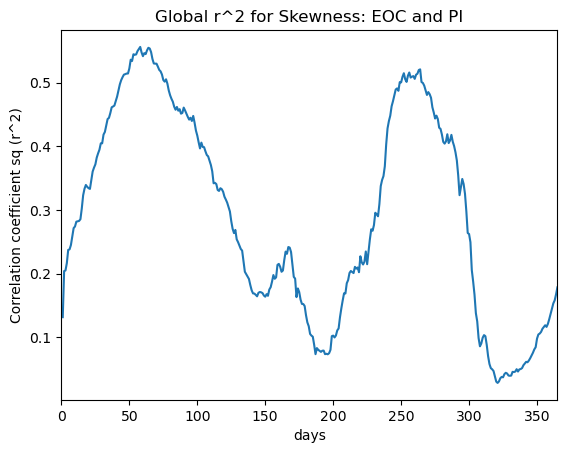

CPU times: user 156 ms, sys: 14.1 ms, total: 170 ms
Wall time: 247 ms


In [31]:
%%time
skew_corr = xr.open_zarr(skew_corrpath)
skew_corr = skew_corr.TREFHTMX
plt.plot(skew_corr.day,skew_corr**2)
plt.title('Global r^2 for Skewness: EOC and PI')
plt.xlabel('days')
plt.ylabel('Correlation coefficient sq (r^2)')
plt.xlim([0,365])
plt.show()

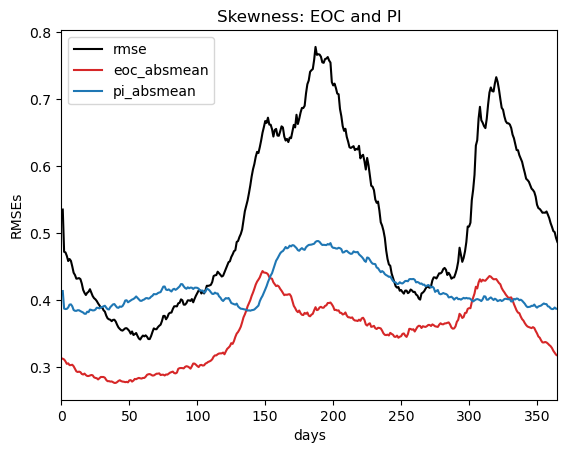

CPU times: user 5.99 s, sys: 288 ms, total: 6.27 s
Wall time: 22.6 s


In [32]:
%%time
plt.plot(skew_rmse.day,skew_rmse,'k',label='rmse',)
plt.plot(skew_rmse.day, skew_geoc_absmean, label='eoc_absmean',color='tab:red')
plt.plot(skew_rmse.day, skew_gpi_absmean, label='pi_absmean', color='tab:blue')
plt.title('Skewness: EOC and PI')
plt.xlabel('days')
plt.ylabel('RMSEs')
plt.legend(loc='upper left')
plt.xlim([0,365])
plt.show()

In [33]:
######## Now, compute correlation only for DJF ############

In [34]:
# Identify the indices corresponding to DJF season
dec_indices = list(range(335, 366))  # Indices for December (31 days)
jan_indices = list(range(1, 32))  # Indices for January (31 days)
feb_indices = list(range(32, 60))  # Indices for February (28/29 days)
djf_indices =  jan_indices + feb_indices + dec_indices
#djf_indices

In [35]:
%%time
skew_geocDJF = skew_geoc.sel(day=djf_indices)
skew_gpiDJF  = skew_gpi.sel(day=djf_indices)
skew_corrDJF = xr.corr(skew_geocDJF,skew_gpiDJF,dim={'lat','lon'})
# skew_maeDJF  = xs.mae(skew_geocDJF,skew_gpiDJF,dim='day')
#
# ax            = plt.axes(projection=cart.crs.PlateCarree())
# skew_maeDJF.plot.contourf(ax=ax,transform=cart.crs.PlateCarree())
# ax.coastlines(color="black")
# plt.title('MAE Skewness, DJF')
# plt.show()

CPU times: user 351 ms, sys: 18.1 ms, total: 369 ms
Wall time: 1.05 s


In [36]:
%%time
skew_geoc_data = skew_geoc.stack(data=('lat','lon','day'))
skew_gpi_data  = skew_gpi.stack(data=('lat','lon','day'))
#skew_gpi_data

CPU times: user 589 ms, sys: 1.3 s, total: 1.89 s
Wall time: 1.79 s


<xarray.DataArray 'TREFHTMX' (data: 20183040)>
dask.array<reshape, shape=(20183040,), dtype=float32, chunksize=(20183040,), chunktype=numpy.ndarray>
Coordinates:
    member   int64 dask.array<chunksize=(), meta=np.ndarray>
    year     int64 dask.array<chunksize=(), meta=np.ndarray>
  * data     (data) object MultiIndex
  * lat      (data) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * lon      (data) float64 0.0 0.0 0.0 0.0 0.0 ... 358.8 358.8 358.8 358.8
  * day      (data) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365

In [39]:
%%time
skew_gcorr     = xr.corr(skew_geoc_data,skew_gpi_data)
skew_gcorr_sq  = skew_gcorr**2
skew_gcorr_sq.values

CPU times: user 10.1 s, sys: 9.71 s, total: 19.8 s
Wall time: 23 s


array(0.23133078)

In [36]:
# %%time
# plt.scatter(skew_gpi_data,skew_geoc_data)
# plt.ylabel('skew EOC')
# plt.xlabel('skew PI')
# plt.show()

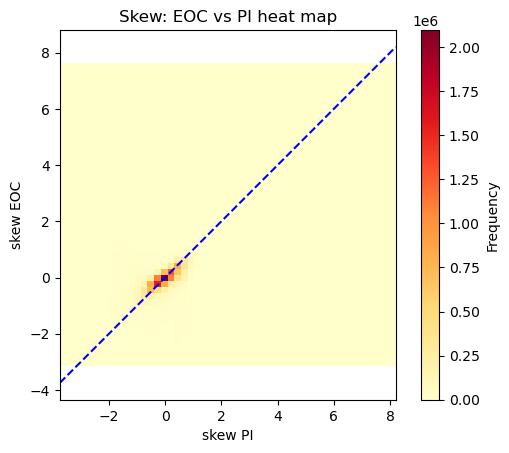

CPU times: user 27 s, sys: 1.86 s, total: 28.9 s
Wall time: 27.1 s


In [37]:
%%time
heatmap, xedges, yedges = np.histogram2d(skew_gpi_data, skew_geoc_data, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# Define a custom colormap
cmap = plt.cm.get_cmap('YlOrRd')  # Choose the colormap (yellow to red)
#cmap.set_under('lightyellow')    # Set the color for lower frequencies
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap=cmap)
plt.colorbar(label='Frequency')
plt.xlabel('skew PI')
plt.ylabel('skew EOC')
max_extent = max(extent[1], extent[3])
# Add the y=x line
plt.plot([extent[0], max_extent], [extent[0], max_extent], color='blue', linestyle='--')
plt.title('Skew: EOC vs PI heat map')
plt.show()

In [38]:
%%time 
#### Save skew correlations (pearson) ######
skew_corr_djfpath      = cvals+'skew_corr_eoc_pi_DJF.zarr'
# skew_corrDJF.to_dataset().to_zarr(skew_corr_djfpath,mode='w')

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 49.4 µs


In [39]:
# %%time
# skew_corrDJF = xr.open_zarr(skew_corr_djfpath)
# skew_corrDJF = skew_corrDJF.TREFHTMX
# #### Skewness correlation coeff #####
# plt.plot(skew_corrDJF.day,skew_corrDJF**2)
# plt.title('Global r^2 for Skewness: EOC and PI')
# plt.xlabel('days')
# plt.ylabel('Correlation coefficient sq (r^2)')
# plt.xlim([0,365])
# plt.show()

In [40]:
###### Check effect of changing skewness using Skew normal distribution #########
# The ppf method of scipy.stats.skewnorm can give the quantile function of the skewnormal distribution

In [41]:
# parameters
a      = 2.175  # shape
delta  = a/np.sqrt(1+a**2)
omega  = 1/np.sqrt(1-2*delta**2/np.pi)
loc    = - omega*delta*np.sqrt(2/np.pi) # location
###
#print('delta,omega,loc=',delta,omega,loc)
###########
mean, var, skew    = skewnorm.stats(a,loc=loc,scale=omega,moments='mvs')
print(mean, var, skew)
# quantile or inverse CDF at quantiles
quants  = np.arange(0.001,1.0,0.001)
qnormal = skewnorm.ppf(quants,0,0,1)
qskew   = skewnorm.ppf(quants,a,loc=loc,scale=omega)
qsnormal= gauss_quantile(0,1,quants)

0.0 1.0000000000000002 0.5003153782056573


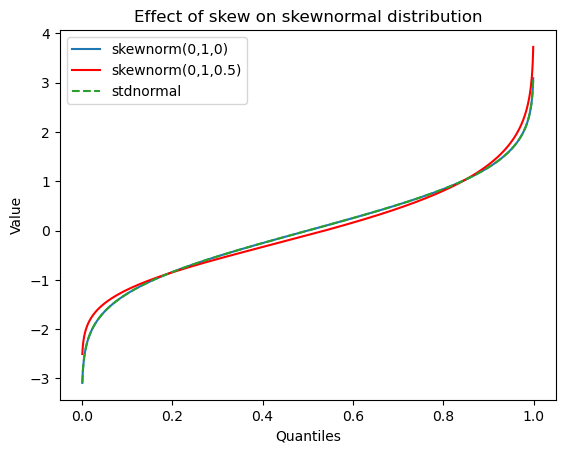

CPU times: user 2 s, sys: 189 ms, total: 2.19 s
Wall time: 2.06 s


In [42]:
%%time
plt.plot(quants,qnormal,label='skewnorm(0,1,0)',color='tab:blue')
plt.plot(quants,qskew,label='skewnorm(0,1,0.5)',color='red')
plt.plot(quants,qsnormal,'--',color='tab:green',label='stdnormal')
plt.title('Effect of skew on skewnormal distribution')
plt.ylabel('Value')
plt.xlabel('Quantiles')
plt.legend(loc='upper left')
plt.show()

In [43]:
skew_rmse_check = mean_squared_error(qskew,qnormal,squared=False)
skew_rmse_check

0.11536301150626256

In [ ]:
############# Skew normal approx to EOC and PI ##########

In [44]:
########## Check moments of observed (ERA5) data #######

In [45]:
tera = xr.open_zarr(era5_noleap_path)
tera = tera.tasmax
tera = tera.chunk({'day':10})
#tera

,Array,Chunk
Bytes,4.87 GiB,18.99 MiB
Shape,"(105, 237, 72, 365)","(105, 237, 10, 10)"
Count,601 Tasks,296 Chunks
Type,float64,numpy.ndarray


In [46]:
tera_roll    = tera.rolling(year=30, center=True).construct('index', stride=1)
tera_roll    = tera_roll.sel(year=slice(1965,2007))
tera_roll

,Array,Chunk
Bytes,87.30 GiB,1.28 GiB
Shape,"(105, 237, 43, 365, 30)","(105, 237, 23, 10, 30)"
Count,2216 Tasks,74 Chunks
Type,float64,numpy.ndarray


In [56]:
tera_sroll = tera_roll.std('index')
tera_sroll = tera_sroll.chunk({'year':43})
tera_sroll

,Array,Chunk
Bytes,2.91 GiB,81.64 MiB
Shape,"(105, 237, 43, 365)","(105, 237, 43, 10)"
Count,2475 Tasks,37 Chunks
Type,float64,numpy.ndarray


In [57]:
%%time
era_srollpath = cvals+'era5_sroll_1950_2021.zarr'
#tera_sroll.to_dataset().to_zarr(era_srollpath,mode='w')

CPU times: user 1min 33s, sys: 5.24 s, total: 1min 38s
Wall time: 3min 7s


In [59]:
tera_sroll = xr.open_zarr(era_srollpath)
tera_sroll = tera_sroll.tasmax
tera_sroll

,Array,Chunk
Bytes,2.91 GiB,81.64 MiB
Shape,"(105, 237, 43, 365)","(105, 237, 43, 10)"
Count,38 Tasks,37 Chunks
Type,float64,numpy.ndarray


In [60]:
%%time
tera_sroll_gmean = global_mean(tera_sroll)
tera_sroll_gmean

CPU times: user 249 ms, sys: 18 ms, total: 267 ms
Wall time: 250 ms


<xarray.DataArray 'tasmax' (year: 43, day: 365)>
dask.array<truediv, shape=(43, 365), dtype=float64, chunksize=(43, 10), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * year     (year) int64 1965 1966 1967 1968 1969 ... 2003 2004 2005 2006 2007

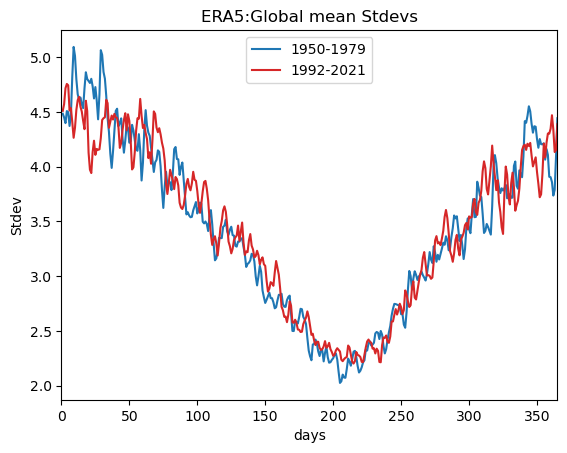

CPU times: user 8.12 s, sys: 494 ms, total: 8.62 s
Wall time: 8.47 s


In [62]:
%%time
plt.plot(tera_sroll_gmean.day,tera_sroll_gmean.sel(year=1965),'tab:blue',label='1950-1979')
plt.plot(tera_sroll_gmean.day,tera_sroll_gmean.sel(year=2007),'tab:red',label='1992-2021')
plt.title('ERA5:Global mean Stdevs')
plt.xlabel('days')
plt.ylabel('Stdev')
plt.legend(loc='upper center')
plt.xlim([0,365])
#plt.ylim([0,35])
plt.show()

In [ ]:
############# Skew normal approx to EOC and PI##########